https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

# IMPORT LIBARIES

In [19]:
# Data processing
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
import json

# Model
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, TextClassificationPipeline
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from torch import softmax

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, auc, roc_curve
import evaluate

# Visualization
from seaborn import heatmap
from matplotlib import pyplot as plt


# LOAD DATA

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [ ]:
train.head(3)

,train_idx,text,label,label_text
0,0,i really do recommend this to anyone in need o...,1,positive
1,1,very good every day camera fits nicely in the ...,1,positive
2,2,"but , dollar for dollar , this dvd player is p...",1,positive


In [ ]:
test.head(3)

,test_idx,text
0,0,fm receiver it has none
1,1,"the picture quality surprised me , when i firs..."
2,2,great video clip quality for a digital camera ...


In [ ]:
# check if any colulumn has null values
train.isnull().sum()

train_idx     0
text          0
label         0
label_text    0
dtype: int64

In [ ]:
test.isnull().sum()

test_idx    0
text        0
dtype: int64

In [ ]:
train["label"].value_counts()

1    1926
0    1090
Name: label, dtype: int64

<Axes: >

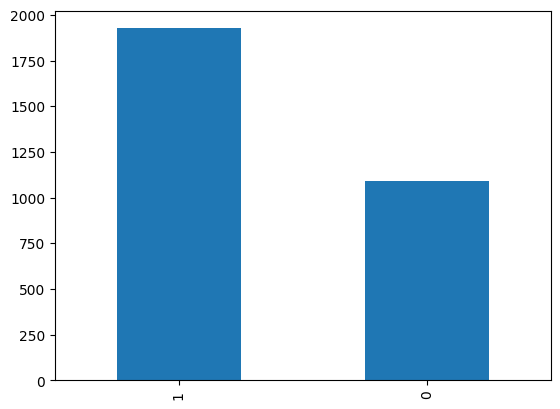

In [ ]:
train["label"].value_counts().plot(kind='bar')

# TESTING MODEL

In [ ]:
from transformers import pipeline
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
print(test['text'][np.random.randint(0, len(test))], "\n", sentiment_task(test['text'][np.random.randint(0, len(test))]))


a bit disappoint on that ! 
 [{'label': 'positive', 'score': 0.7560573816299438}]


# MODEL

In [18]:
# Read the data
train = pd.read_csv('data/train.csv')
train_standalone = train[['text', 'label']]

# Split the data into train and validation
train_split, val_split = np.split(train_standalone.sample(frac=1, random_state=42), [int(.8*len(train))])

# Convert pyhton dataframe to Hugging Face arrow dataset
train_split_dt = Dataset.from_pandas(train_split)
val_split_dt = Dataset.from_pandas(val_split)

#define the model
model_name = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'

# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["text"], 
                     max_length=32, 
                     truncation=True, 
                     padding="max_length")

# Tokenize the dataset
train_encoding = train_split_dt.map(tokenize_dataset)
val_encoding = val_split_dt.map(tokenize_dataset)

# Load model
#model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
model = XLMRobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment', num_labels=2, ignore_mismatched_sizes=True)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./models/content/models/twitter-xlm-roberta-base-sentiment",          
    logging_dir='./models/content/logs/twitter-xlm-roberta-base-sentiment',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=6,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True,
)

# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encoding,
    eval_dataset=val_encoding,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

Map:   0%|          | 0/2412 [00:00<?, ? examples/s]

Map:   0%|          | 0/604 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\crist\universidad\3_PI_CNN\ProyIng_Grupo2\env\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3618 [00:00<?, ?it/s]

{'loss': 0.428, 'learning_rate': 4.166666666666667e-06, 'epoch': 1.0}


  0%|          | 0/151 [00:00<?, ?it/s]

{'eval_loss': 0.3866165280342102, 'eval_accuracy': 0.902317880794702, 'eval_runtime': 44.1579, 'eval_samples_per_second': 13.678, 'eval_steps_per_second': 3.42, 'epoch': 1.0}
{'loss': 0.276, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.0}


  0%|          | 0/151 [00:00<?, ?it/s]

{'eval_loss': 0.46142861247062683, 'eval_accuracy': 0.9056291390728477, 'eval_runtime': 42.4334, 'eval_samples_per_second': 14.234, 'eval_steps_per_second': 3.559, 'epoch': 2.0}
{'train_runtime': 3160.3121, 'train_samples_per_second': 4.579, 'train_steps_per_second': 1.145, 'train_loss': 0.3520322454904838, 'epoch': 2.0}


TrainOutput(global_step=1206, training_loss=0.3520322454904838, metrics={'train_runtime': 3160.3121, 'train_samples_per_second': 4.579, 'train_steps_per_second': 1.145, 'train_loss': 0.3520322454904838, 'epoch': 2.0})

# TEST

In [32]:
# Read test data
test = pd.read_csv('data/test.csv')

# Convert pyhton dataframe to Hugging Face arrow dataset
test_dt = Dataset.from_pandas(test)

# Tokenize the test dataset
test_encoding = test_dt.map(tokenize_dataset)

# Use the trained model to make predictions on the test dataset
raw_predictions = trainer.predict(test_encoding)

# Convert raw predictions to probabilities and predicted labels
probs = softmax(torch.tensor(raw_predictions.predictions), dim=1).numpy()
pred_labels = np.argmax(probs, axis=1)

# Create a dictionary that maps test_idx to predicted labels
#predictions = {"target": {}}
#for i, test_id in enumerate(test["test_idx"]):
   # predictions["target"][test_id] = {test_id: int(pred_labels[i])}
predictions = {"target": {str(test['test_idx'][i]): int(pred_labels[i]) for i in range(len(test))}}

    
# Save the predictions to a JSON file
with open('predictions.json', 'w') as f:
    json.dump(predictions, f)


Map:   0%|          | 0/754 [00:00<?, ? examples/s]